# Parte 2 - Modelos de Previsão

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import warnings 
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

## Importando os datasets da Parte 1

In [2]:
sns.set()
weekly_train = pd.read_csv('../../data/Marcos/weekly_m.csv')
hourly_train = pd.read_csv('../../data/Marcos/hourly_m.csv')
daily_train = pd.read_csv('../../data/Marcos/daily_m.csv')
data_test = pd.read_csv('../../data/ElectricDemandForecasting-DL-master_data_hourly_20140102_20191101_test.csv')

C:\Users\Not\Anaconda2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


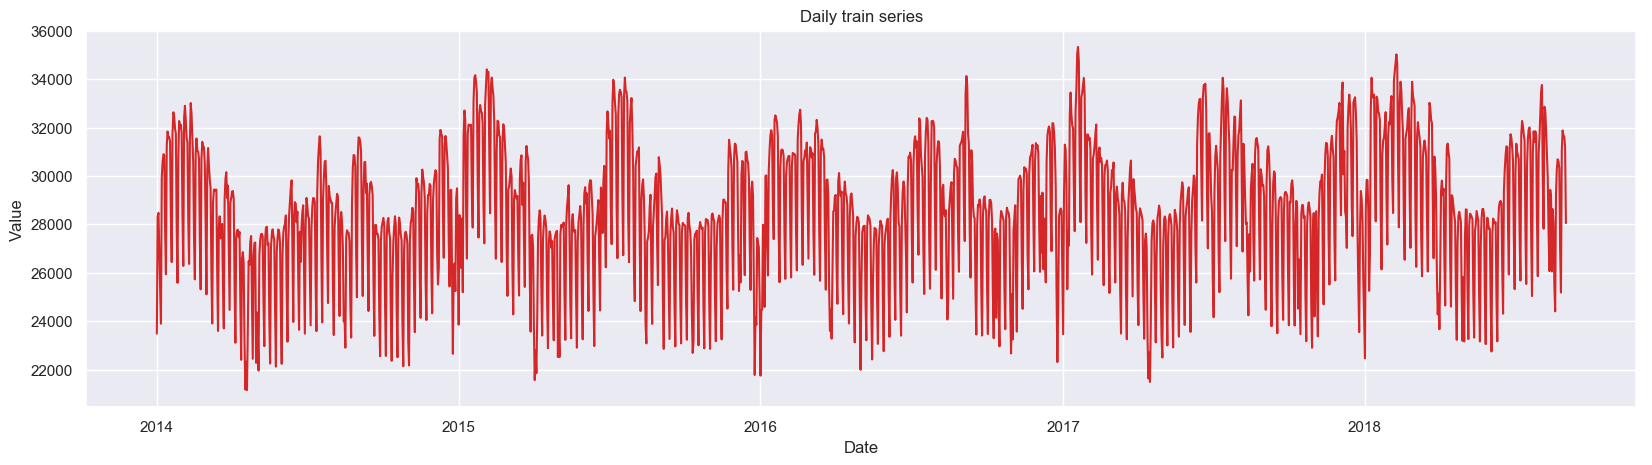

In [3]:
weekly_train['datetime'] = pd.to_datetime(weekly_train["datetime"])
hourly_train['datetime'] = pd.to_datetime(hourly_train["datetime"])
daily_train['datetime'] = pd.to_datetime(daily_train["datetime"])


plot_df(daily_train, x=daily_train['datetime'], y=daily_train['value'], title="Daily train series")

## Tratando o dataset de teste

In [4]:
data_test['datetime'] = pd.to_datetime(data_test['datetime'], utc=True)
data_test_daily = data_test.groupby([pd.Grouper(key='datetime', freq='D')])['value'].mean().reset_index()
data_test_weekly = data_test.groupby([pd.Grouper(key='datetime', freq='W-SUN')])['value'].mean().reset_index()

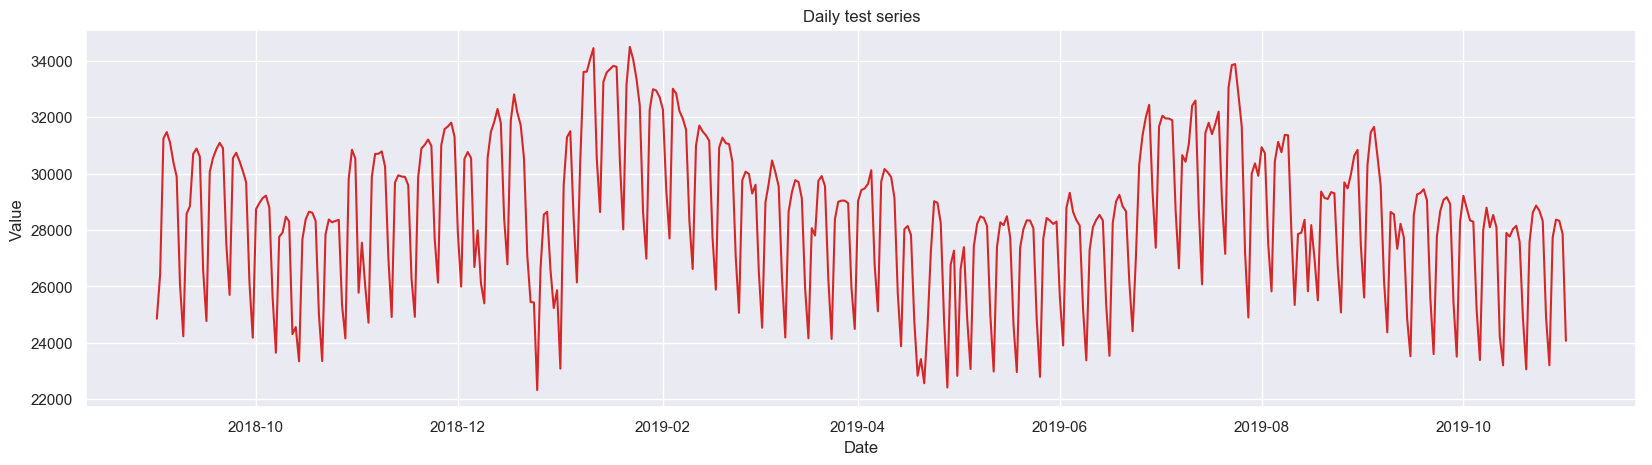

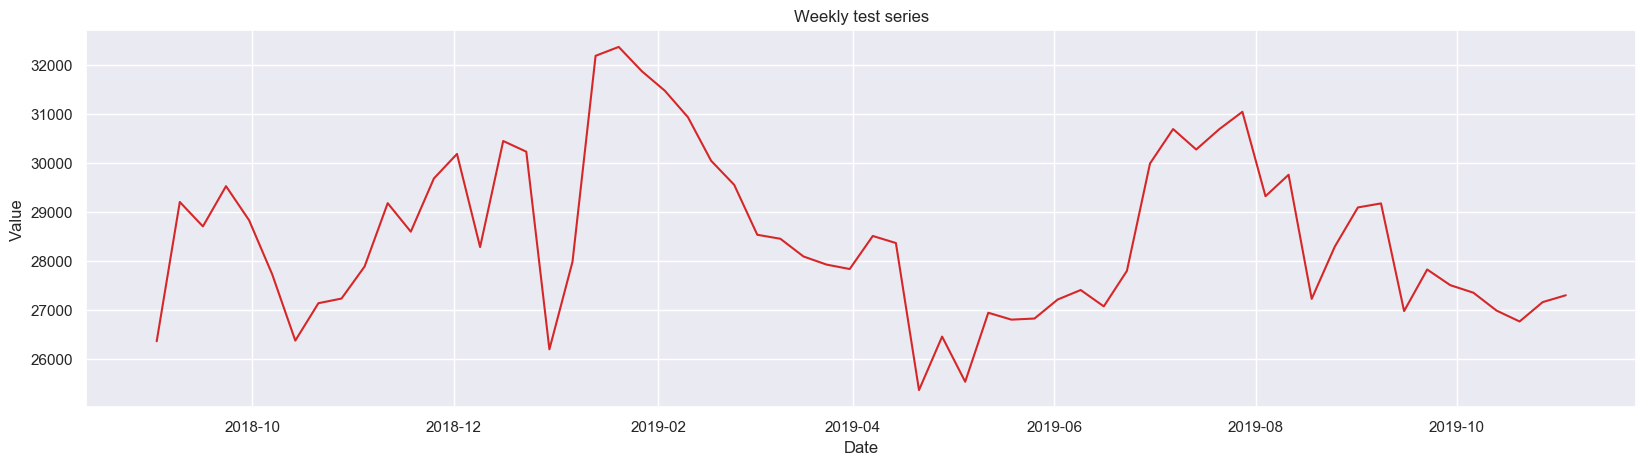

In [5]:
plot_df(data_test_daily, x=data_test_daily.datetime, y=data_test_daily.value, title="Daily test series")
plot_df(data_test_weekly, x=data_test_weekly.datetime, y=data_test_weekly.value, title="Weekly test series")

# Modelos de Previsão

## Modelo Trivial - Naive approach

### Naive para dados diários

,Real,Previsto
0,24853.500000,28049.608696
1,26426.680556,24853.500000
2,31247.444444,26426.680556
3,31470.652778,31247.444444
4,31096.166667,31470.652778


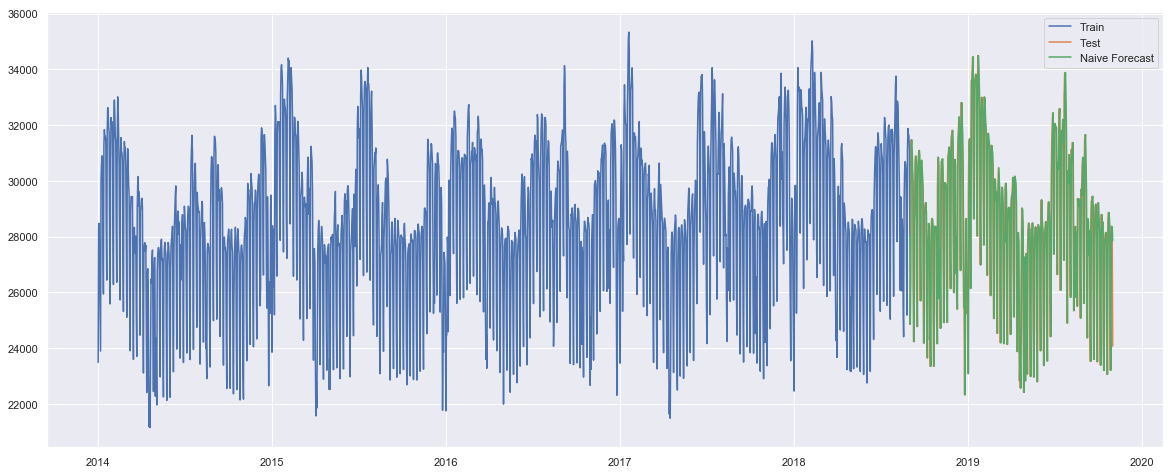

In [39]:
actual_values = data_test_daily['value']
data_train_history = [x for x in daily_train['value']]
predictions = list()
for i in range(len(actual_values)):
    predictions.append(data_train_history[-1])
    data_train_history.append(actual_values[i])
    
data_predict = data_test_daily.copy()
data_predict['value'] = predictions
plt.figure(figsize=(20,8))
plt.plot(daily_train['datetime'], daily_train['value'], label='Train')
plt.plot(data_test_daily['datetime'],data_test_daily['value'], label='Test')
plt.plot(data_predict['datetime'],data_predict['value'], label='Naive Forecast')
plt.legend(loc='best')

table_results_df = pd.DataFrame(data=data_test_daily['value'], columns=['Real']) 
table_results_df['Real']=data_test_daily['value']
table_results_df['Previsto'] = predictions
table_results_df.head()

### Naive para dados semanais

,Real,Previsto
0,26363.753333,30932.329837
1,29204.251984,26363.753333
2,28706.025794,29204.251984
3,29527.029762,28706.025794
4,28831.158730,29527.029762


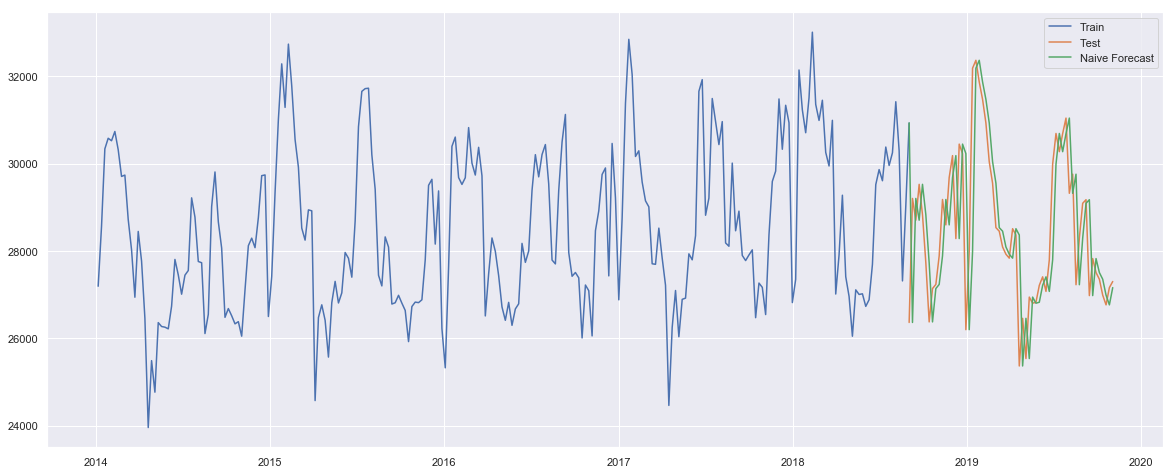

In [38]:
actual_values = data_test_weekly['value']
data_train_history = [x for x in weekly_train['value']]
predictions = list()
for i in range(len(actual_values)):
    predictions.append(data_train_history[-1])
    data_train_history.append(actual_values[i])
    
data_predict = data_test_weekly.copy()
data_predict['value'] = predictions
plt.figure(figsize=(20,8))
plt.plot(weekly_train['datetime'], weekly_train['value'], label='Train')
plt.plot(data_test_weekly['datetime'],data_test_weekly['value'], label='Test')
plt.plot(data_predict['datetime'],data_predict['value'], label='Naive Forecast')
plt.legend(loc='best')

table_results_df = pd.DataFrame(data=data_test_weekly['value'], columns=['Real']) 
table_results_df['Real']=data_test_weekly['value']
table_results_df['Previsto'] = predictions
table_results_df.head()

## Modelo de Alisamento Exponencial 

### Alisamento Exponencial - Dados diários

,Real,Previsto
0,24853.500000,[29360.318997004564]
1,26426.680556,[26656.227598801823]
2,31247.444444,[26518.49937285406]
3,31470.652778,[29355.86641580829]
4,31096.166667,[30624.738232989985]


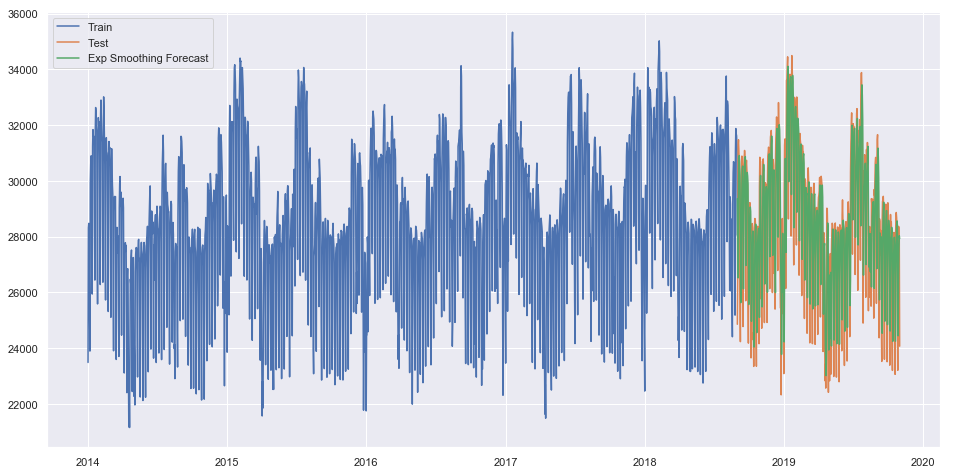

In [40]:
actual_values = data_test_daily['value']
data_train_history = [x for x in daily_train['value']]
predictions = list()
alpha = 1
for i in range(len(actual_values)):
    model_fit = SimpleExpSmoothing(data_train_history).fit(smoothing_level=0.6,optimized=False)
    predictions.append(model_fit.predict(len(data_train_history),len(data_train_history)))
    data_train_history.append(actual_values[i])
    
data_predict = data_test_daily.copy()
data_predict['value'] = predictions
plt.figure(figsize=(16,8))
plt.plot(daily_train['datetime'], daily_train['value'], label='Train')
plt.plot(data_test_daily['datetime'],data_test_daily['value'], label='Test')
plt.plot(data_predict['datetime'],data_predict['value'], label='Exp Smoothing Forecast')
plt.legend(loc='best')

table_results_df = pd.DataFrame(data=data_test_daily['value'], columns=['Real']) 
table_results_df['Real']=data_test_daily['value']
table_results_df['Previsto'] = predictions
table_results_df.head()


### Alisamento Exponencial - Dados Semanais

,Real,Previsto
0,26363.753333,[30105.768527317276]
1,29204.251984,[27860.55941092691]
2,28706.025794,[28666.77495484696]
3,29527.029762,[28690.32545812926]
4,28831.158730,[29192.34804039456]


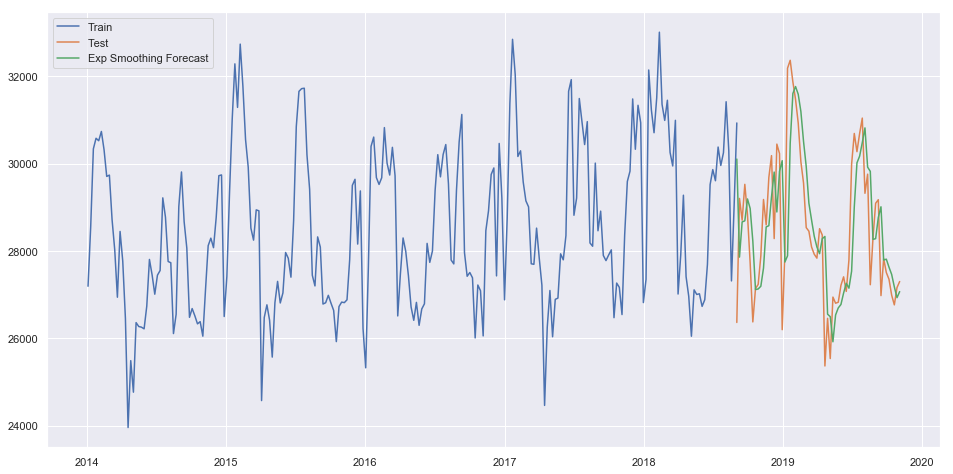

In [41]:
actual_values = data_test_weekly['value']
data_train_history = [x for x in weekly_train['value']]
predictions = list()
alpha = 1
for i in range(len(actual_values)):
    model_fit = SimpleExpSmoothing(data_train_history).fit(smoothing_level=0.6,optimized=False)
    predictions.append(model_fit.predict(len(data_train_history),len(data_train_history)))
    data_train_history.append(actual_values[i])
    
data_predict = data_test_weekly.copy()
data_predict['value'] = predictions
plt.figure(figsize=(16,8))
plt.plot(weekly_train['datetime'], weekly_train['value'], label='Train')
plt.plot(data_test_weekly['datetime'],data_test_weekly['value'], label='Test')
plt.plot(data_predict['datetime'],data_predict['value'], label='Exp Smoothing Forecast')
plt.legend(loc='best')

table_results_df = pd.DataFrame(data=data_test_weekly['value'], columns=['Real']) 
table_results_df['Real']=data_test_weekly['value']
table_results_df['Previsto'] = predictions
table_results_df.head()

## Modelo de Holts-Winter

### Holts-Winter - Dados Diários

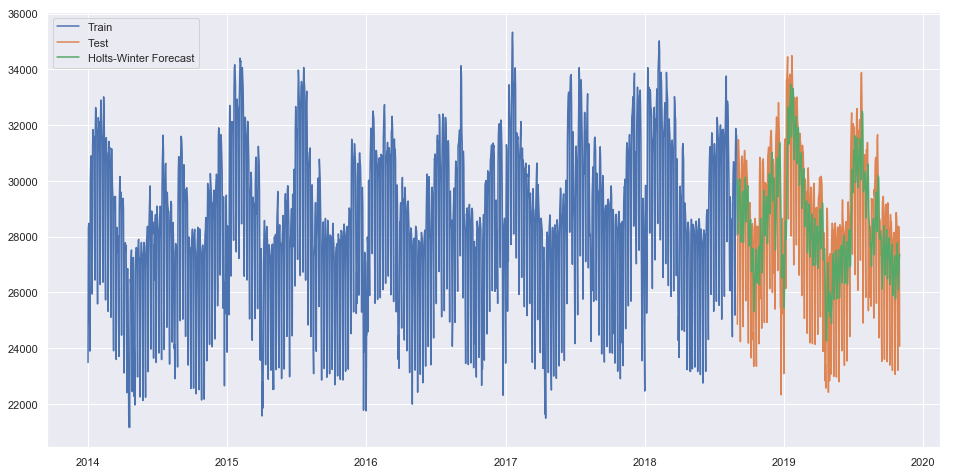

,Real,Previsto
0,24853.500000,[30053.692759764406]
1,26426.680556,[28730.32337613758]
2,31247.444444,[28090.245529083506]
3,31470.652778,[28889.986637477836]
4,31096.166667,[29522.962011527932]


In [42]:
actual_values = data_test_daily['value']
data_train_history = [x for x in daily_train['value']]
predictions = list()
for i in range(len(actual_values)):
    model_fit = ExponentialSmoothing(data_train_history, trend='add', seasonal='add', seasonal_periods=2).fit()
    predictions.append(model_fit.predict(len(data_train_history),len(data_train_history)))
    data_train_history.append(actual_values[i])
    
data_predict = data_test_daily.copy()
data_predict['value'] = predictions
plt.figure(figsize=(16,8))
plt.plot(daily_train['datetime'], daily_train['value'], label='Train')
plt.plot(data_test_daily['datetime'],data_test_daily['value'], label='Test')
plt.plot(data_predict['datetime'],data_predict['value'], label='Holts-Winter Forecast')
plt.legend(loc='best')
plt.show()

table_results_df = pd.DataFrame(data=data_test_daily['value'], columns=['Real']) 
table_results_df['Real']=data_test_daily['value']
table_results_df['Previsto'] = predictions
table_results_df.head()

### Holts-Winter - Dados Semanais

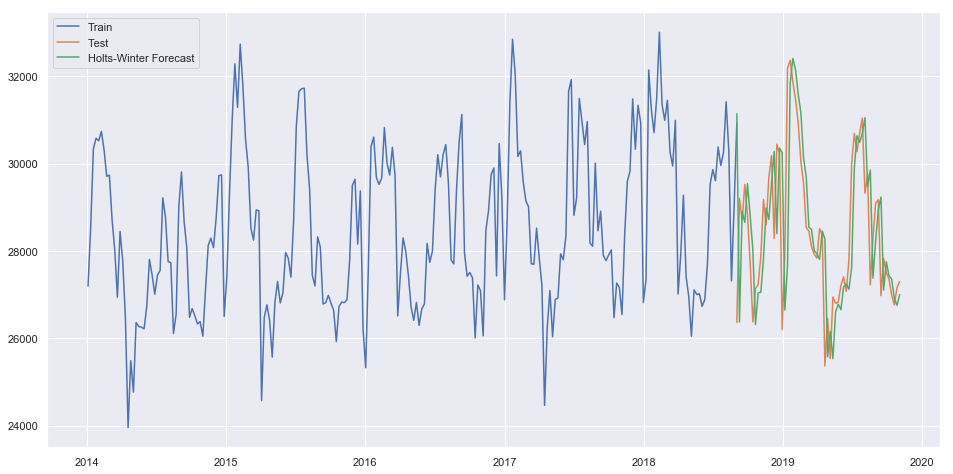

,Real,Previsto
0,26363.753333,[31141.77064699593]
1,29204.251984,[26373.785185963858]
2,28706.025794,[28904.47034097236]
3,29527.029762,[28656.497792995815]
4,28831.158730,[29542.506914396377]


In [43]:
actual_values = data_test_weekly['value']
data_train_history = [x for x in weekly_train['value']]
predictions = list()
for i in range(len(actual_values)):
    model_fit = ExponentialSmoothing(data_train_history, trend='add', seasonal='add', seasonal_periods=2).fit()
    predictions.append(model_fit.predict(len(data_train_history),len(data_train_history)))
    data_train_history.append(actual_values[i])
    
data_predict = data_test_weekly.copy()
data_predict['value'] = predictions
plt.figure(figsize=(16,8))
plt.plot(weekly_train['datetime'], weekly_train['value'], label='Train')
plt.plot(data_test_weekly['datetime'],data_test_weekly['value'], label='Test')
plt.plot(data_predict['datetime'],data_predict['value'], label='Holts-Winter Forecast')
plt.legend(loc='best')
plt.show()

table_results_df = pd.DataFrame(data=data_test_weekly['value'], columns=['Real']) 
table_results_df['Real']=data_test_weekly['value']
table_results_df['Previsto'] = predictions
table_results_df.head()

## Modelo ARIMA

In [117]:
from pyramid.arima import auto_arima

C:\Users\Not\Anaconda2\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [118]:
stepwise_fit = auto_arima(weekly_train["value"], start_p = 1, start_q = 1, 

                          max_p = 3, max_q = 3, seasonal = False, 

                          d = 1, trace = True, 

                          error_action ='ignore',   # we don't want to know if an order does not work 

                          suppress_warnings = True)           # set to stepwise 

  
# To print the summary 
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=4153.107, BIC=4167.079, Fit time=0.840 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4180.565, BIC=4187.551, Fit time=0.059 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4182.155, BIC=4192.634, Fit time=0.292 seconds
Fit ARIMA: order=(0, 1, 1); AIC=4181.565, BIC=4192.044, Fit time=0.111 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4163.197, BIC=4180.662, Fit time=0.666 seconds
Fit ARIMA: order=(1, 1, 2); AIC=4162.637, BIC=4180.102, Fit time=0.604 seconds
Fit ARIMA: order=(2, 1, 2); AIC=4164.410, BIC=4185.369, Fit time=0.849 seconds
Total fit time: 3.494 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  243
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2072.554
Method:                       css-mle   S.D. of innovations           1215.122
Date:                Tue, 27 Oct 2020   AIC                           4153.107
Time:                        19:34:48   BIC                           4167.079
Sample:                             1   HQIC                          4158.735
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4422      4.002      1.610      0.109      -1.402      14.287
ar.L1.D.y      0.7330      0.044     16.505      0.000       0.646       0.820
ma.L1.D.y     -1.0000      0.010    -95.875      0.000      -1.020      -0.980
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3643           +0.0000j            1.3643            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [121]:
model_arima = ARIMA(weekly_train['value'], order=(1,1,1))
model_fit_arima = model_arima.fit()
print(model_fit_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  243
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2072.554
Method:                       css-mle   S.D. of innovations           1215.122
Date:                Tue, 27 Oct 2020   AIC                           4153.107
Time:                        19:35:44   BIC                           4167.079
Sample:                             1   HQIC                          4158.735
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.4422      4.002      1.610      0.109      -1.402      14.287
ar.L1.D.value     0.7330      0.044     16.505      0.000       0.646       0.820
ma.L1.D.value    -1.0000      0.010    -

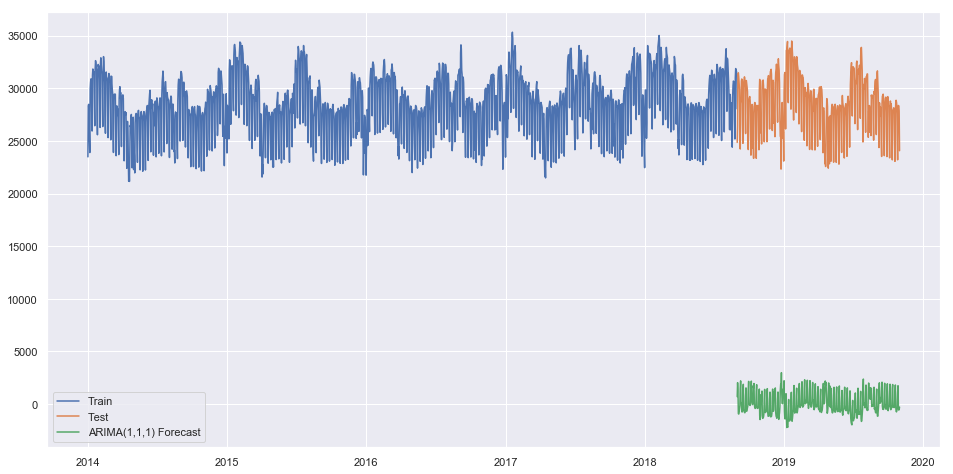

,Real,Previsto
0,24853.500000,[702.2439882212498]
1,26426.680556,[2032.2502437037876]
2,31247.444444,[1232.6232583866283]
3,31470.652778,[-914.2771823787825]
4,31096.166667,[-954.032495335035]


In [44]:
actual_values = data_test_daily['value']
data_train_history = [x for x in daily_train['value']]
predictions = list()
for i in range(len(actual_values)):
    model_fit = ARIMA(data_train_history,order=(1,1,1)).fit()
    predictions.append(model_fit.predict(len(data_train_history),len(data_train_history)))
    data_train_history.append(actual_values[i])

    df_predict = data_test_daily.copy()
df_predict['value'] = predictions
plt.figure(figsize=(16,8))
plt.plot(daily_train['datetime'], daily_train['value'], label='Train')
plt.plot(data_test_daily['datetime'],data_test_daily['value'], label='Test')
plt.plot(df_predict['datetime'],df_predict['value'], label='ARIMA(1,1,1) Forecast')
plt.legend(loc='best')
plt.show()

table_results_df = pd.DataFrame(data=data_test_daily['value'], columns=['Real']) 
table_results_df['Real']=data_test_daily['value']
table_results_df['Previsto'] = predictions
table_results_df.head()